# Springboard Time Series - 'Cowboy Cigarettes' Case Study - Tier 3

## Brief

You're working in the US federal government as a data scientist in the Health and Environment department. You've been tasked with determining whether sales for the oldest and most powerful producers of cigarettes in the country are increasing or declining. 

**Cowboy Cigarettes (TM, *est.* 1890)** is the US's longest-running cigarette manufacturer. Like many cigarette companies, however, they haven't always been that public about their sales and marketing data. The available post-war historical data runs for only 11 years after they resumed production in 1949; stopping in 1960 before resuming again in 1970. Your job is to use the 1949-1960 data to predict whether the manufacturer's cigarette sales actually increased, decreased, or stayed the same. You need to make a probable reconstruction of the sales record of the manufacturer - predicting the future, from the perspective of the past - to contribute to a full report on US public health in relation to major cigarette companies. 

The results of your analysis will be used as part of a major report relating public health and local economics, and will be combined with other studies executed by your colleagues to provide important government advice.  

-------------------------------
As ever, this notebook is **tiered**, meaning you can elect that tier that is right for your confidence and skill level. There are 3 tiers, with tier 1 being the easiest and tier 3 being the hardest.  

**1. Sourcing and loading** 
- Load relevant libraries 
- Load the data
- Explore the data

 
**2. Cleaning, transforming and visualizing**
- Dropping unwanted columns
- Nomenclature
- Type conversions
- Making a predictor variable `y` 
- Getting summary statistics for `y`
- Plotting `y`
  
  
**3. Modelling** 
- Decomposition
    - Trend
    - Seasonality
    - Noise
- Testing for stationarity with KPSS
- Making the data stationary
- The ARIMA Model
    - Make a function to find the MSE of a single ARIMA model
    - Make a function to evaluate the different ARIMA models with different p, d, and q values
- Visualize the results
- Application: Forecasting

**4. Evaluating and concluding** 
- What is our conclusion?
- Next steps
    

## 0. Preliminaries 

Time series data is just any data displaying how a single variable changes over time. It comes as a collection of metrics typically taken at regular intervals. Common examples of time series data include weekly sales data and daily stock prices. You can also easily acquire time series data from [Google Trends](https://trends.google.com/trends/?geo=US), which shows you how popular certain search terms are, measured in number of Google searches. 

## 1. Sourcing and Loading

### 1a. Load relevant libraries 

In [1]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

if os.getcwd() not in sys.path:
    sys.path.insert(0, os.getcwd())

### 1b. Load the data
Call the variable `cigData`. 

In [2]:
CigData = pd.read_csv('./CowboyCigsData.csv')

### 1c. Explore the data
We now need to check whether the data conduces to a time series style analysis.

In [3]:
display(CigData.head())
display(CigData.info())
display(CigData.describe().T)

,Unnamed: 0,Time,#CigSales
0,0,1949-01,1000112
1,1,1949-02,1000118
2,2,1949-03,1000132
3,3,1949-04,1000129
4,4,1949-05,1000121


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  144 non-null    int64 
 1   Time        144 non-null    object
 2   #CigSales   144 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 3.5+ KB


None

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,144.0,7.150000e+01,41.713307,0.0,35.75,71.5,107.25,143.0
#CigSales,144.0,1.000280e+06,119.966317,1000104.0,1000180.00,1000265.5,1000360.50,1000622.0


Over a million cigarettes sold in the month of January 1949. This certainly is a popular cigarette brand. 

<font color='teal'>There are three columns, one of which is the index (`Unnamed: 0`). Also, there is no Null values.

## 2. Cleaning, transforming and visualizing

### 2a. Dropping unwanted columns
We need to cut that `Unnamed: 0` column. Delete it here.

In [4]:
CigData.drop('Unnamed: 0', axis=1, inplace=True)

### 2b. Nomenclature

We can see that the `Time` column actually has the granularity of months. Change the name of that column to `Month`.

In [5]:
CigData.rename(columns=dict(Time='Month'), inplace=True)

### 2c. Type conversions 

Now, do time series analysis on a Pandas dataframe is overkill, and is actually counter-productive. It's much more easy to carry out this type of analysis if we convert our data to a series first.

Notice that the `Month` field was an object. Let's type convert the `Month` column to a Python `datetime`, before making that the index.

In [6]:
CigData['Month'] = pd.to_datetime(CigData.Month, format='%Y-%m')

# Judged by the length of the dataframe (=144), it seems to have all
# the year we need, but let's make it sure since it's really important for 
# time series analysis to have constant time steps.

# It's expected to have all the months during 1949 and 1960.
exp_set = set(pd.date_range(start='1949-01', end='1960-12', freq='MS'))
act_set = set(CigData.Month)  # Actual months in the df
diff = exp_set - act_set  # Difference between expected and actual month 

if diff:
    print('There is missing month(s):', ', '.join(list(diff)))
else:
    print('There is no missing month')

There is no missing month


In [7]:
# Now that we are sure there is no issue with `Month` column,
# let's convert it to index
CigData.set_index('Month', inplace=True)
CigData.head()

,#CigSales
Month,
1949-01-01,1000112
1949-02-01,1000118
1949-03-01,1000132
1949-04-01,1000129
1949-05-01,1000121


Perfect! 

### 2d. Making a dependent variable `y`

The data is now indexed by date, as time series data ought to be. Extract pandas.Series for Models.

In [8]:
y = CigData['#CigSales']

### 2e. Getting summary statistics for `y`

<font color='teal'>We already know from the above.</font>

### 2f. Plotting `y`

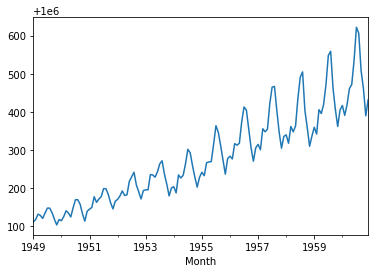

In [9]:
y.plot();

## 3. Modelling 
### 3a. Decomposition
What do you notice from the plot? Take at least `2` minutes to examine the plot, and write down everything you observe.  

All done?

We can see that, generally, there is a trend upwards in cigarette sales from at Cowboy Cigarettes. But there are also some striking - and perhaps unexpected - seasonal fluctuations. These seasonal fluctations come in a repeated pattern. Work out when these seasonal fluctuations are happening, and take 2 minutes to hypothesize on their cause here.

What does it mean to *decompose* time series data? It means breaking that data into 3 components: 

1. **Trend**: The overall direction that the data is travelling in (like upwards or downwards)
2. **Seasonality**: Cyclical patterns in the data 
3. **Noise**: The random variation in the data <br>
<font color='teal'>The point 3 is not necessarily a noise, it's rather sum of random variables and errors, so residual is better word.</font>

We can treat these components differently, depending on the question and what's appropriate in the context. They can either be added together in an *additive* model, or multiplied together in a *multiplicative* model. 

Make a coffee, take `5` minutes and read [this article](https://medium.com/@sigmundojr/seasonality-in-python-additive-or-multiplicative-model-d4b9cf1f48a7) and think about whether our data would conduce to an additive or multiplicative model here. Write your conclusion down just here: 

-------------------------------

All done? Well, just on the basis of the plot above, it seems our Cowboy Cigarettes data is actually multiplicative. 

That's because, as time progresses, the general trend seems to be increasing *at a rate that's also increasing*. We also see that the seasonal fluctuations (the peaks and troughs) get bigger and bigger as time progresses.

Now on the other hand, if the data were simply additive, we could expect the general trend to increase at a *steadily*, and a constant speed; and also for seasonal ups and downs not to increase or decrease in extent over time.

Happily, we can use the `decompose()` function to quantify the component parts described above in our data.<br>
<font color='teal'> You mean `seasonal_decompose()`, I suppose?</font>

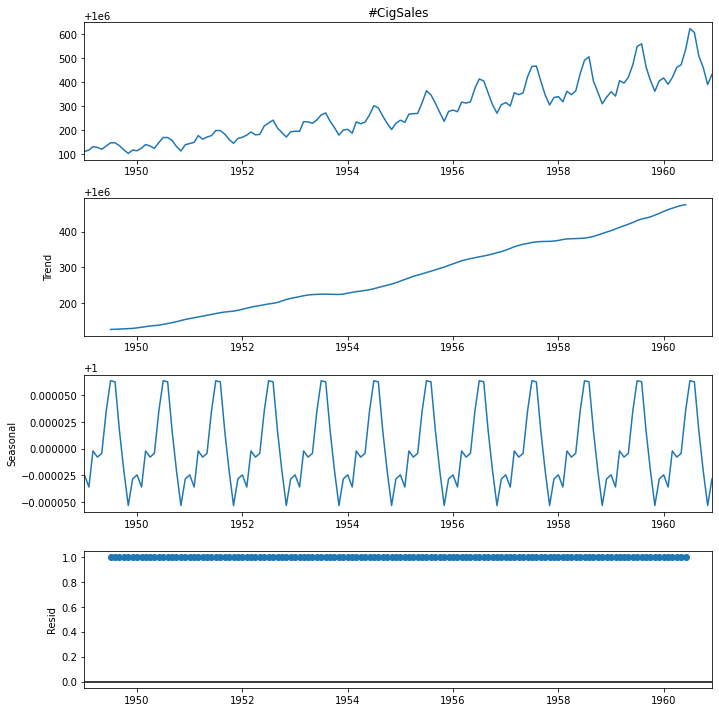

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
dec_res = seasonal_decompose(y, model='multiplicative')

# Plot the original data, the trend, the seasonality, and the residuals 
fig = dec_res.plot()
fig.set_size_inches((10, 10))
fig.tight_layout()

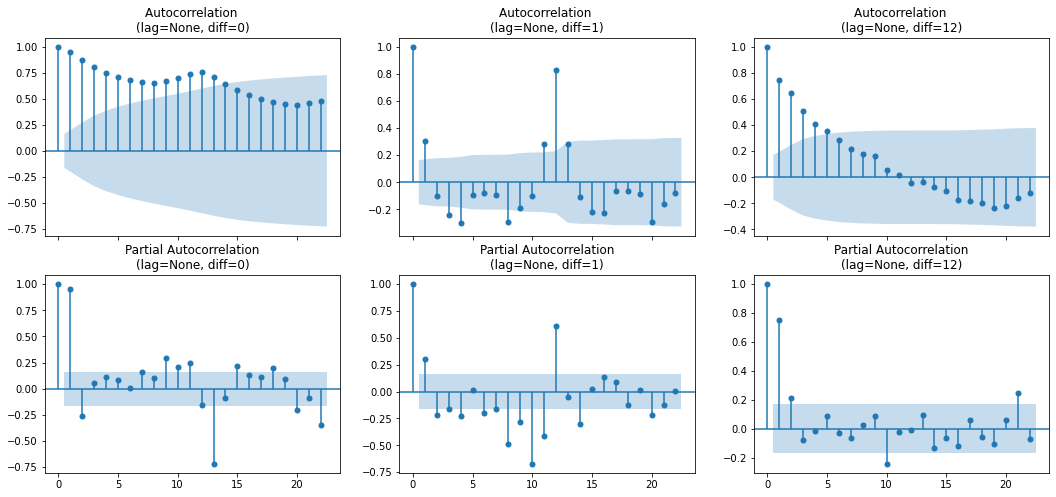

In [11]:
# Plot ACF
from src import plot_acfs

# ACF/PACF plots with no diff, 1st diff, 12th diffs.
plot_acfs(y, periods=[0, 1, 12])

Though we can't see any seasonality nor trend from ACF plot of the raw `y` data, but from the ACF plot of 1st diff (the top middle plot), we can see seasonal pattern.<br>

ARIMA model and its siblings are linear functions of previously observed data: <br>
AR Model: $ y_t = \alpha_1 y_{t-1} + \alpha_2 y_{t-2} + ... +\alpha_n y_{t-n} + \epsilon_t$ <br>
MA Model: $ y_t = \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + ... + \theta_m \epsilon_{t-m} + \epsilon_t$ <br>
Where $y_t$ is the dependent value at the time $t$, $\epsilon_t$ is the error term for time $t$, $n$ is AR order, and $m$ is MA order.<br>
And ARIMA model is a linear combination of AR model, MA model, and integral part:<br>
ARIMA Model: $ y_t = \beta + \alpha_1 y_{t-1} + \alpha_2 y_{t-2} + ... +\alpha_n y_{t-n} + \epsilon_t$ <br>
Thanks to the constant term $\beta$, ARIMA model can handle non-stationary data.

<font color='teal'>Now, Our time series data is multiplicative, which means: $y_t = Seasonality * Trend * Residuals$ <br>Note that Seasonalioty and Trend correspond to 'integral' terms in ARIMA model and Residual part is comprised of AR and MA terms. We need to take $log$ to make the model linear.</font><br>

$log(y_t) = log(Seasonality * Trend * Residuals) = log(Seasonality) + log(Trend) + log(Residuals)$<br>

In [12]:
log_y = np.log(y)

### 3b. Testing for stationarity with KPSS
As you know, when doing time series analysis we always have to check for stationarity. Imprecisely, a time series dataset is stationary just if its statistical features don't change over time. A little more precisely, a stationary time series dataset will have constant mean, variance, and covariance.

There are many ways to test for stationarity, but one of the most common is the KPSS test. The Null hypothesis of this test is that the time series data in question is stationary; hence, if the *p*-value is less than the significance level (typically 0.05, but we decide) then we reject the Null and infer that the data is not stationary.

In [13]:
from statsmodels.tsa.stattools import adfuller, kpss
warnings.filterwarnings('ignore')

print('KPSS statistic: {:.3f}\nKPSS p-value  : {:.3f}'.format(*kpss(log_y.values)[:2]))

# Following DataCamp, I also use Augmented Dickey-Fuller test 
# where Null hypothesis is that y is non-stationary.
print('ADF statistic: {:.3f}\nADF p-value  : {:.3f}'.format(*adfuller(log_y.values)[:2]))

KPSS statistic: 1.052
KPSS p-value  : 0.010
ADF statistic: 0.815
ADF p-value  : 0.992


Since our p-value is greater than 0.05, we should reject the Null hypothesis and deduce the non-stationarity of our data.<br>
But our data need to be stationary to apply any variant of ARMA model. So we need to do some transforming.

### 3c. Making the data stationary 

In our plot, we can see that both the mean and the variance *increase as time progresses*. At the moment, our data has neither a constant mean, nor a constant variance (the covariance, however, seems constant). 

One often  used way of getting rid of changing variance is to take the natural log of all the values in our dataset. Let's do this now. 

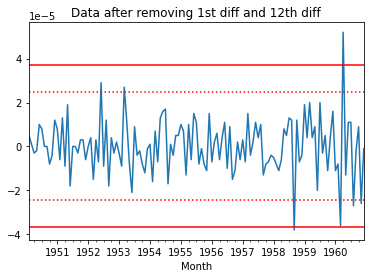

In [14]:
# Taking 1st and then 12th diff.
diff_y = log_y.diff().diff(12).dropna()

std = diff_y.std()
mean = diff_y.mean()

# Plot the diff data
ax = diff_y.plot()
ax.set_title('Data after removing 1st diff and 12th diff')
ax.axhline(mean+3*std, c='red')
ax.axhline(mean+2*std, c='red', linestyle=':')
ax.axhline(mean-2*std, c='red', linestyle=':')
ax.axhline(mean-3*std, c='red')
plt.show()

In [15]:
# Check the stationarity
print('KPSS statistic: {:.3f}\nKPSS p-value  : {:.3f}'.format(*kpss(diff_y.values)[:2]))
print('ADF statistic: {:.3f}\nADF p-value  : {:.3f}'.format(*adfuller(diff_y.values)[:2]))

KPSS statistic: 0.087
KPSS p-value  : 0.100
ADF statistic: -15.596
ADF p-value  : 0.000


Our p-value is now greater than 0.05, so we can accept the null hypothesis that our data is stationary.

### 3d. The ARIMA model

Recall that ARIMA models are based around the idea that it's possible to predict the next value in a time series by using information about the most recent data points. It also assumes there will be some randomness in our data that can't ever be predicted.

We can find some good parameters for our model using the `sklearn` and `statsmodels` libraries, and in particular `mean_squared_error` and `ARIMA`. 

In [16]:
# Now, as instructed, find the best ARIMA model based on MSE
# Note that even though we do know there is seasonality, we ignore that
# for now (maybe we don't need that much accuracy), and use ARIMA which
# cannot handle seasonality.
from src import select_best_model
from statsmodels.tsa.arima_model import ARIMA

# Take 20% of data as test data, perform step-forward optimization,
# and select best model based on MSE.
p = q = [*range(3)]
d = [*range(2)]

ARIMA_best_order = select_best_model(log_y, ARIMA, p, d, q)

So the best p,d, q, parameters for our ARIMA model are 2, 1, 1 respectively. Now we know this, we can build the model.

We can take a look at a summary of the model this library has built around our data.

In [17]:
best_ARIMA = ARIMA(log_y, ARIMA_best_order[0][1]).fit()
ARIMA_mse = {
    'res': best_ARIMA,
    'AIC': best_ARIMA.aic,
    'MSE': ARIMA_best_order[0][0]
}

In [18]:
display(ARIMA_mse['res'].summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.#CigSales   No. Observations:                  143
Model:                 ARIMA(2, 1, 1)   Log Likelihood                1263.116
Method:                       css-mle   S.D. of innovations              0.000
Date:                Sun, 30 Aug 2020   AIC                          -2516.233
Time:                        04:47:27   BIC                          -2501.418
Sample:                    02-01-1949   HQIC                         -2510.213
                         - 12-01-1960                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              2.624e-06   5.06e-07      5.184      0.000    1.63e-06    3.62e-06
ar.L1.D.#CigSales     0.4681      0.156      3.003      0.003       0.163       0.774
ar.L2.D.#CigSales    -0.2640      0.109     -2.413      0.016      -0.478      -0.050
ma.L1.D.#CigSales    -0.8693        nan        nan        nan         nan         nan
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.8866           -1.7326j            1.9463           -0.1747
AR.2            0.8866           +1.7326j            1.9463            0.1747
MA.1            1.1504           +0.0000j            1.1504            0.0000
-----------------------------------------------------------------------------
"""

<font color='teal'>Now, I'd like to take seasonality into account.</font>

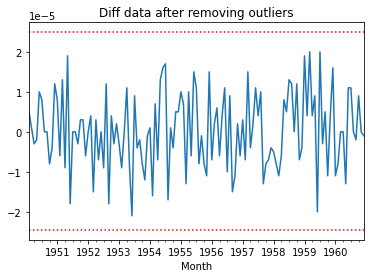

In [19]:
# Even though the diff data above is stationary, we have outliers (lesser 
# or greater than mean +- 2 * std.)
# Let's replace them since SARIMA model could't fit successfully when I 
# kept them as-is.
updated_diff_y = diff_y.copy()

# Replace outliers with median.
is_outlier = (updated_diff_y > mean + 2*std) | (updated_diff_y < mean - 2*std)
updated_diff_y[is_outlier] = updated_diff_y.median()

# plot the updated diff data
ax = updated_diff_y.plot()
ax.axhline(mean+2*std, c='red', linestyle=':')
ax.axhline(mean-2*std, c='red', linestyle=':')
ax.set_title('Diff data after removing outliers')
plt.show()

In [20]:
# Check stationarity
import warnings
from statsmodels.tsa.stattools import adfuller, kpss
warnings.filterwarnings('ignore')

print(adfuller(updated_diff_y)[:2])  # Expected to be less than 0.05  (Null hypothesis is having trend)
print(kpss(updated_diff_y)[:2])  # Expected to be more than 0.05 (Null hypothesis is stationarity)

(-13.67213618198927, 1.4529535459666382e-25)
(0.1704643959979079, 0.1)


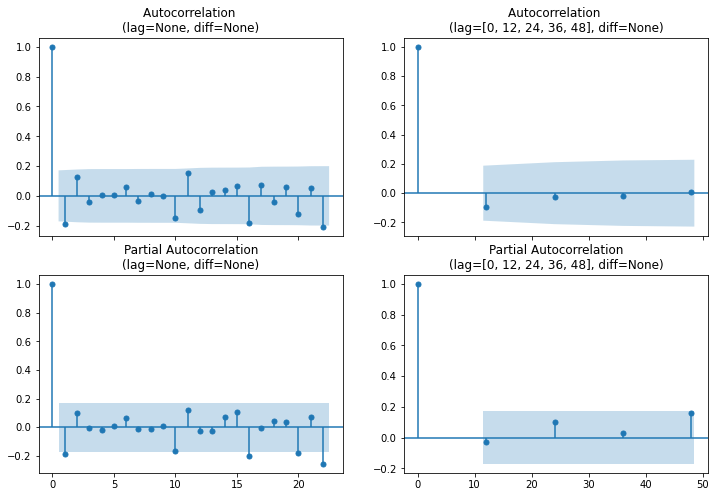

In [21]:
# Now that the data is stationary, let's check the ACF again.
plot_acfs(updated_diff_y, lags=[None, [12*i for i in range(5)]])

From the plots on the left, where lags are `n`, ACF and PACF cut off at 1st lag.<br>
So, the best order seems to be around `(1, 1, 1)`.

Also, from the plots on the right, where lags are `12 * m`, ACF and PACF cut off at 0th lag.<br>
So, the best seasonal_order seems to be around `(0, 1, 0, 12)`.

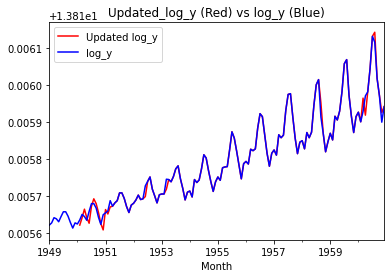

In [22]:
# invert diffs and recover log data
updated_log_y = updated_diff_y.copy()
updated_log_y += log_y.diff().shift(12)
updated_log_y[:14] = log_y.diff()[:14]
updated_log_y += log_y.shift()
updated_log_y[0] = log_y[0]

ax = updated_log_y.plot(color='r', label='Updated log_y')
_ = log_y.plot(color='b', ax=ax, label='log_y')
_ = ax.set_title('Updated_log_y (Red) vs log_y (Blue)')
ax.legend()

In [23]:
# Find the best model based on AIC first.

import pmdarima as pm
model = pm.auto_arima(updated_log_y, seasonal=True, m=12,
                      max_p=5, max_q=5, max_P=5, max_Q=5,
                      trend='ct', # stepwise=False, trace=True,
                      error_action='ignore',
                      suppress_warnings=True)

In [24]:
print(f'Best SARIMA model: SARIMAX({model.order}, {model.seasonal_order})')

Best SARIMA model: SARIMAX((0, 0, 1), (0, 1, 0, 12))


In [25]:
# For comparison aginst the ARIMA model we built,
# calculate MSE using prediction from `updated_log_y` and `log_y`
# as True y.

from statsmodels.tsa.statespace.sarimax import SARIMAX
from src import calc_mse

aic_mse = calc_mse(updated_log_y, SARIMAX, true_series=log_y,
                   order=model.order, seasonal_order=model.seasonal_order,
                   trend='ct')

aic_model = SARIMAX(updated_log_y, order=model.order,
                    seasonal_order=model.seasonal_order,
                    trend='ct').fit()
SARIMA_aic = {
    'res': aic_model,
    'AIC': aic_model.aic,
    'MSE': aic_mse
}

### 3e. Visualize the results 

Visualize the original dataset plotted against our model. <font color='teal'> See the next section</font>

### 3f. Application: Forecasting

We've done well: our model fits pretty closely to our existing data. Let's now use it to forecast what's likely to occur in future.

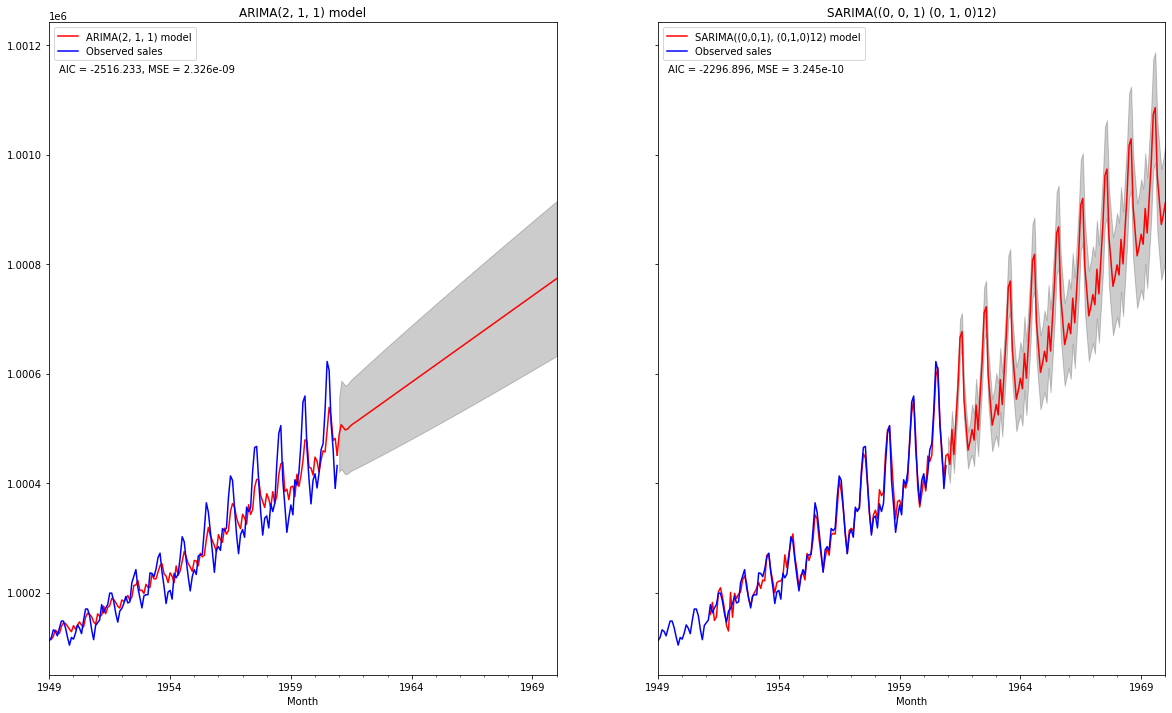

In [27]:
# Prepare SARIMA predictions
SARIMA_pred = SARIMA_aic['res'].get_prediction(start=13, end='1970')
SARIMA_means = SARIMA_pred.predicted_mean
SARIMA_conf_int = SARIMA_pred.conf_int()
SARIMA_conf_int.columns = ['lower', 'upper']
SARIMA_conf_int = SARIMA_conf_int['1961':]  # Limit to forecasting part
# Recover scale
SARIMA_means = np.exp(SARIMA_means)
SARIMA_conf_int = np.exp(SARIMA_conf_int)

# Prepare ARIMA predictions
ARIMA_pred = ARIMA_mse['res'].predict() + log_y.shift(1)
ind = pd.date_range(start='1961', end='1970', freq='MS')
ARIMA_frcst, _, ARIMA_conf_int = best_ARIMA.forecast(steps=len(ind))
ARIMA_frcst = ARIMA_pred[[-1]].append(pd.Series(ARIMA_frcst, index=ind))
ARIMA_conf_int = pd.DataFrame(ARIMA_conf_int, index=ind, columns=['lower', 'upper'])
# Recover scale
ARIMA_pred = np.exp(ARIMA_pred)
ARIMA_frcst = np.exp(ARIMA_frcst)
ARIMA_conf_int = np.exp(ARIMA_conf_int)


# Prepare plots
fig, axes = plt.subplots(1, 2, figsize=(20, 12), sharey=True)

# Plot ARIMA prediction and forecast
ARIMA_pred.plot(ax=axes[0], color='red', label='ARIMA(2, 1, 1) model')
ARIMA_frcst.plot(ax=axes[0], color='red', label='')
# Fill confidence interval
axes[0].fill_between(ARIMA_conf_int.index, ARIMA_conf_int.upper, 
                     ARIMA_conf_int.lower, color='k', alpha=0.2)
# Plot the observed sales
y.plot(ax=axes[0], color='blue', label='Observed sales')
axes[0].text('1949-06', 1.00115e6, f'AIC = {ARIMA_mse["AIC"]:.3f}, MSE = {ARIMA_mse["MSE"]:.3e}')
axes[0].set_title('ARIMA(2, 1, 1) model')
axes[0].legend(loc='upper left')


# Plot SARIMA prediction
SARIMA_means.plot(ax=axes[1], color='red', 
                  label='SARIMA((0,0,1), (0,1,0)12) model')
# Fill confidence interval (alpha = 0.05)
axes[1].fill_between(SARIMA_conf_int.index, SARIMA_conf_int.upper, 
                     SARIMA_conf_int.lower, color='k', alpha=0.2)
# Plot the observed sales
y.plot(ax=axes[1], color='blue', label='Observed sales')
axes[1].text('1949-06', 1.00115e6, f'AIC = {SARIMA_aic["AIC"]:.3f}, MSE = {SARIMA_aic["MSE"]:.3e}')
axes[1].set_title('SARIMA((0, 0, 1) (0, 1, 0)12)')
axes[1].legend(loc='upper left')

plt.show()

Though AIC indicates ARIMA model is better model, SARIMA model has lesser MSE and looks better fit on the plot.

## 4. Evaluating and Concluding

Our model captures the centre of a line that's increasing at a remarkable rate. Cowboy Cigarettes sell more cigarettes in the summer, perhaps due to the good weather, disposable income and time off that people enjoy, and the least in the winter, when people might be spending less and enjoying less free time outdoors. 

Remarkably, our ARIMA model made predictions using just one variable. We can only speculate, however, on the causes of the behaviour predicted by our model. We should also take heed that spikes in data, due to sudden unusual circumstances like wars, are not handled well by ARIMA; and the outbreak of the Vietnam War in the 1960s would likely cause our model some distress.  

We could suggest to our employers that, if they are interested in discovering the causes of the cigarette sales trajectory, they execute a regression analysis in addition to the time series one. 